To launch in SuperCloud from a Computed Node

LLsub -i full #for an exclusive node
LLsub -i -s 40 #for node with 40 CPUs
LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

In [10]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import gymnasium as gym
from gymnasium import spaces
import subprocess
import multiprocessing
import concurrent.futures
import os
import random
from collections import defaultdict
import socket


In [ ]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs: {multiprocessing.cpu_count()}")


Node: d-7-1-1
GPUs: 1
GPU 0: Tesla V100-PCIE-32GB (32494 MB, compute capability 7.0)
CPUs: 80


## Import experimental data

In [4]:
input_signals_list_small_molecules = [
    {0: 0.0278, 1: 0.0022, 2: 0.0042},  # First set of input signals
    {0: 0.0278, 1: 0.0022, 2: 2.0082},  # Second set of input signals
    {0: 0.0278, 1: 5.0543, 2: 0.0042},  # Third set of input signals
    {0: 0.0278, 1: 5.0543, 2: 2.0082},  # First set of input signals
    {0: 3.9239, 1: 0.0022, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 0.0022, 2: 2.0082},  # Third set of input signals    
    {0: 3.9239, 1: 5.0543, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 5.0543, 2: 2.0082},  # Third set of input signals  
]    



input_signals_list_binary = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   


# ## Postech's library characterization

# %%


# Data
repressor_data = {
    "Repressor": ["AmeR", "AmtR", "BetI", "BM3R1", "BM3R1", "BM3R1", "HlyIIR", "IcaRA", "LitR", "LmrA", 
                  "PhlF", "PhlF", "PhlF", "PsrA", "QacR", "QacR", "SrpR", "SrpR", "SrpR", "SrpR"],
    "RBS": ["F1", "A1", "E1", "B1", "B2", "B3", "H1", "I1", "L1", "N1", 
            "P1", "P2", "P3", "R1", "Q1", "Q2", "S1", "S2", "S3", "S4"],
    "ymaxa": [3.835, 5.036, 3.065, 0.543, 0.822, 0.704, 2.462, 3.558, 4.296, 2.152,
              3.901, 6.505, 6.794, 6.489, 3.744, 3.778, 1.216, 2.556, 2.547, 3.314],
    "ymina": [1.06, 0.091, 1e-14, 0.002, 1e-14, 1e-14, 0.057, 1e-14, 0.074, 0.183,
              0.01, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14],
    "Ka": [0.122, 0.022, 0.363, 0.051, 0.285, 0.261, 1e-14, 0.186, 1e-14, 1e-14,
          1e-14, 0.16, 0.167, 0.305, 0.126, 0.456, 1e-14, 0.224, 0.4, 0.108],
    "n": [1.306, 1.308, 1.833, 2.042, 1.685, 1.768, 2.596, 1.085, 1.696, 2.095,
          4, 2.237, 2.01, 1.54, 1.706, 1.979, 1.66, 1.337, 1.569, 1.344],
    "Toxicity (RPU)": ["-", "-", "-", "-", "-", "-", 4.06525, 0.47094, "-", "-", 
                       "-", "-", "-", "-", 4.06525, "-", "-", "-", "-", "-"]
}

# Create DataFrame
cello_v1_hill_function_parameters = pd.DataFrame(repressor_data)

cello_v1_hill_function_parameters


# ## Postech's toxicity data

# %%


# Load the JSON file
file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/gate_toxicity_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

gate_toxicity_df




,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."
5,gate_toxicity,B3_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.971657754, 0.970707071, 1.015062389, 0.9..."
6,gate_toxicity,H1_HlyIIR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.931501911, 0.945850458, 0.941163746, 0.9..."
7,gate_toxicity,I1_IcaRA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.019887906, 1.026628502, 1.028642482, 1.0..."
8,gate_toxicity,L1_LitR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.034190532, 1.017241379, 1.034190532, 1.0..."
9,gate_toxicity,N1_LmrA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.948325359, 0.884901648, 0.884237108, 0.8..."


### Load circuit topology

In [5]:
"""
file_name = "0x09_optimal_topology_ML_1"
with open(file_name, "wb") as f:
    pickle.dump(G_optimized, f)
print(f"Optimal graph saved to {file_name}")
"""

'\nfile_name = "0x09_optimal_topology_ML_1"\nwith open(file_name, "wb") as f:\n    pickle.dump(G_optimized, f)\nprint(f"Optimal graph saved to {file_name}")\n'

In [6]:
'''
file_name = "0x09_optimal_topology_ML_1"
with open(file_name, "rb") as f:
    topology_networkx = pickle.load(f)
print(f"Optimal graph loaded from {file_name}")
'''

'\nfile_name = "0x09_optimal_topology_ML_1"\nwith open(file_name, "rb") as f:\n    topology_networkx = pickle.load(f)\nprint(f"Optimal graph loaded from {file_name}")\n'

In [7]:
#file_name = "0x46_ML_topology_design_with_gates_assigned.pkl"
#file_name = "0x17_ML_topology_design_with_gates_assigned.pkl"
#file_name = "0xE3_ML_topology_design_with_gates_assigned.pkl"
#file_name = "0x7B_ML_topology_design_with_gates_assigned.pkl"
#file_name = "0x7D_ML_topology_design_with_gates_assigned.pkl"

file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/notebooks/0x2B_ML_topology_designs_reduced.pkl"

with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)
    
    
    
selected_graph = 1    
    
topology_networkx = reduced_graphs[selected_graph]     

### Plot topology

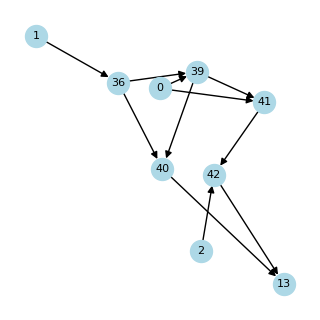

In [8]:
# Define the layout
def small_topology_plot(graph_networkx):
    pos = nx.spring_layout(graph_networkx)
    color = 'lightblue'
    plt.figure(figsize=(3, 3))
    nx.draw(graph_networkx, pos, with_labels=False, node_color=color, node_size=250, font_size=10, font_weight='bold')
    nx.draw_networkx_labels(graph_networkx, pos, font_size=8, font_color='black')
    plt.show()
    
small_topology_plot(topology_networkx)    

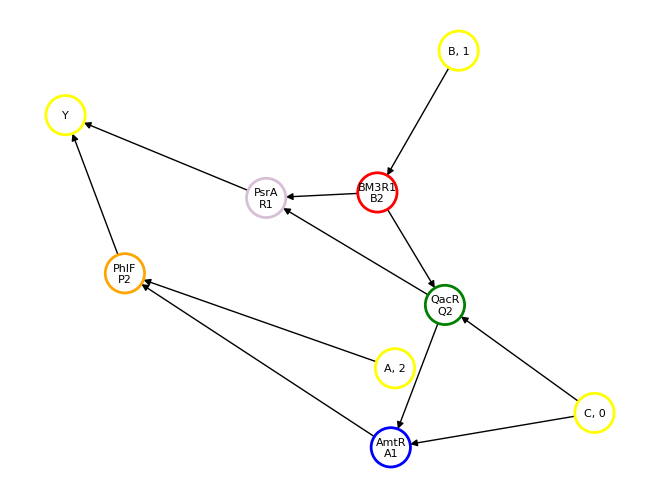

In [11]:
output_nodes = [n for n in topology_networkx if topology_networkx.out_degree(n) == 0]
output_node = output_nodes[0]
results_check_implicit_OR_existence = check_implicit_OR_existence_v3(topology_networkx, output_node, 2)
for key, value in results_check_implicit_OR_existence.items():
    if value["is_there_an_implicit_OR"]:
        topology_networkx_with_implicit_OR = add_implicit_OR_to_dag(topology_networkx)
        adj_matrix_sparse = nx.adjacency_matrix(topology_networkx_with_implicit_OR)
        adj_matrix_dense = adj_matrix_sparse.toarray()
        print("Here")
    else:
        #topology_networkx_with_implicit_OR = topology_networkx
        adj_matrix_sparse = nx.adjacency_matrix(topology_networkx)
        adj_matrix_dense = adj_matrix_sparse.toarray()

adj_matrix = adj_matrix_dense
G = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, [ 4, 15, 13,  1, 11])
draw_network_with_colors_and_labels_from_G(G)

## Find permutation of the inputs

In [12]:
# Define the input nodes
input_nodes = [0, 1, 2]

In [13]:
def permute_graph(graph, permutation):
    # Create a mapping from old node to new node
    mapping = {old: new for old, new in zip(input_nodes, permutation)}
    # Create a new graph with the permuted nodes
    permuted_graph = nx.relabel_nodes(graph, mapping)
    return permuted_graph

# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))

# Create a list to store the permuted graphs
permuted_graphs = []

# Generate and store the permuted graphs
for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm)
    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        print("perm: ", perm)
        permuted_graphs.append(new_graph)

perm:  (0, 1, 2)
perm:  (1, 0, 2)


## Plot permutations

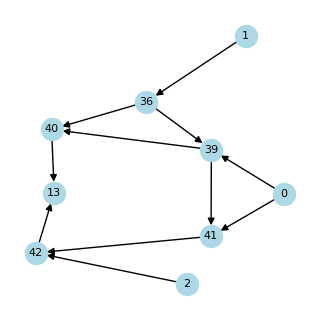

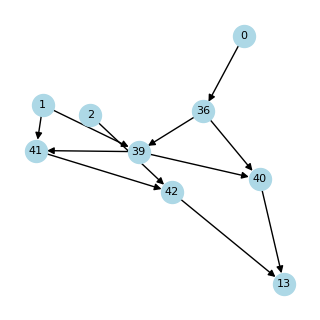

### Adquire data from objective objective function 

#### Load possible permutations without repeating repressor

In [15]:
elements = list(range(20))
r = 5

# Define the constraint once, right where it’s easiest to tweak
my_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

valid_permutations = generate_and_filter_permutations_v2(elements, r, my_groups, max_per_group=1)

print(f"{len(valid_permutations):,} permutations meet the criteria")

Processing permutations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1860480/1860480 [00:03<00:00, 485474.39it/s]

875,520 permutations meet the criteria


In [31]:
#OLD fucntion

valid_permutations_previous_functions = generate_and_filter_permutations(elements, r)


len(valid_permutations_previous_functions)


In [32]:
same = set(valid_permutations) == set(valid_permutations_previous_functions)
print("Exactly the same:", same)   

In [ ]:
file_path = 'valid_permutations_5_gates.h5'
valid_permutations = load_valid_permutations(file_path)
print(f"Total valid permutations loaded: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

#### Adquire data (multiple cores)

In [16]:
def save_accumulated_results(accumulated_results, file_number, output_dir):
    """
    Save accumulated results to a file
    
    Parameters:
    -----------
    accumulated_results : list
        List of results to save
    file_number : int
        Current file number for naming
    output_dir : str
        Directory to save the file
        
    Returns:
    --------
    list
        Empty list to reset accumulator
    """
    output_file = os.path.join(output_dir, f"results_large_batch_{file_number}.pkl")
    try:
        with open(output_file, 'wb') as f:
            pickle.dump(accumulated_results, f)
        print(f"Successfully saved {len(accumulated_results):,} solutions to {output_file}")
    except Exception as e:
        print(f"Error saving file {output_file}: {str(e)}")
    return []  # Return empty list to reset accumulator

def process_permutation_batch(batch_data):
    """
    Process a single batch of permutations
    """
    batch_id, adj_matrix, cello_params, input_signals_small, input_signals_binary, gate_toxicity_df, permutations = batch_data
    
    batch_results = []
    for current_solution in permutations:
        # Create test graph
        Gtest = assign_representations_with_io_nodes_3(
            adj_matrix,
            cello_params,
            current_solution
        )
        
        # Calculate toxicity
        toxicity_score, _ = calculate_toxicity_score(
            input_signals_small,
            Gtest,
            gate_toxicity_df
        )
        
        # Simulate logic
        actual_logic = simulate_signal_propagation(
            Gtest,
            input_signals_small
        )
        expected_logic = simulate_signal_propagation_binary(
            Gtest,
            input_signals_binary
        )
        
        # Calculate scores
        current_score = calculate_circuit_score(expected_logic, actual_logic)
        roadblocking_flag = is_roadblocking(Gtest)
        
        batch_results.append({
            'circuit_score': current_score,
            'toxicity_score': toxicity_score,
            'roadblocking_flag': roadblocking_flag[0],
            'permutation': current_solution
        })
    
    return batch_id, batch_results


def parallel_process_circuits(adj_matrix, valid_permutations, cello_params,
                            input_signals_small, input_signals_binary,
                            gate_toxicity_df, output_dir,
                            num_samples=2000000, batch_size=1000,
                            solutions_per_file=None):
    """
    Process a random subset of circuit solutions using all available cores
    and save results in configurable large chunks
    
    Parameters:
    -----------
    ... [previous parameters] ...
    solutions_per_file : int, optional
        Number of solutions to accumulate before saving to a file.
        If None, automatically sets to num_samples/10 (default)
        Min value is batch_size, max value is num_samples
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Set default solutions_per_file if not specified
    if solutions_per_file is None:
        solutions_per_file = num_samples // 10  # Default to 10 files total
    else:
        # Ensure solutions_per_file is between batch_size and num_samples
        solutions_per_file = max(batch_size, min(solutions_per_file, num_samples))
    
    num_cores = multiprocessing.cpu_count()
    print(f"Utilizing all {num_cores} cores for parallel processing")
    print(f"Solutions per file: {solutions_per_file:,}")
    print(f"Expected number of files: {num_samples // solutions_per_file + bool(num_samples % solutions_per_file)}")
    
    # Generate random indices for the subset
    print(f"Selecting {num_samples:,} random solutions from {len(valid_permutations):,} valid permutations")
    random_indices = random.sample(range(len(valid_permutations)), num_samples)
    selected_permutations = [valid_permutations[i] for i in random_indices]
    
    # Find the highest file number already saved
    existing_files = [f for f in os.listdir(output_dir) 
                     if f.startswith("results_large_batch_") and f.endswith(".pkl")]
    current_file_number = 0
    if existing_files:
        max_file_num = max(int(f.split('_')[-1].split('.')[0]) for f in existing_files)
        current_file_number = max_file_num + 1
    
    # Calculate total solutions already processed
    solutions_processed = current_file_number * solutions_per_file
    if solutions_processed >= num_samples:
        print("All solutions have already been processed")
        return
    
    start_time = time.time()
    
    # Prepare common data
    common_data = (adj_matrix, cello_params, input_signals_small, 
                  input_signals_binary, gate_toxicity_df)
    
    # Create batches for remaining solutions
    remaining_permutations = selected_permutations[solutions_processed:]
    total_batches = (len(remaining_permutations) + batch_size - 1) // batch_size
    
    # Prepare all batch data
    batch_data_list = []
    for batch_number in range(total_batches):
        start_idx = batch_number * batch_size
        end_idx = min(start_idx + batch_size, len(remaining_permutations))
        current_batch_permutations = remaining_permutations[start_idx:end_idx]
        
        batch_data = (batch_number,) + common_data + (current_batch_permutations,)
        batch_data_list.append(batch_data)
    
    print(f"Processing {len(batch_data_list)} batches using {num_cores} cores")
    
    accumulated_results = []
    processed_solutions = solutions_processed
    
    # Process all batches using all cores
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
        futures = [executor.submit(process_permutation_batch, batch_data) 
                  for batch_data in batch_data_list]
        
        with tqdm(total=len(batch_data_list), desc="Processing batches", 
                 unit="batch") as pbar:
            
            for future in concurrent.futures.as_completed(futures):
                try:
                    batch_id, batch_results = future.result()
                    accumulated_results.extend(batch_results)
                    processed_solutions += len(batch_results)
                    
                    # Save when we've accumulated enough solutions
                    if len(accumulated_results) >= solutions_per_file:
                        print(f"\nSaving file {current_file_number} with {len(accumulated_results):,} solutions...")
                        save_accumulated_results(
                            accumulated_results, 
                            current_file_number,
                            output_dir
                        )
                        accumulated_results = []  # Reset accumulator
                        current_file_number += 1
                    
                    # Update progress
                    elapsed_time = time.time() - start_time
                    remaining_batches = len(batch_data_list) - pbar.n
                    time_per_batch = elapsed_time / (pbar.n + 1)
                    remaining_time = remaining_batches * time_per_batch
                    
                    pbar.set_postfix({
                        'Solutions': f'{processed_solutions:,}/{num_samples:,}',
                        'Elapsed': f'{elapsed_time/60:.1f}min',
                        'Remaining': f'{remaining_time/60:.1f}min',
                        'Solutions/sec': f'{processed_solutions/elapsed_time:.1f}'
                    })
                    pbar.update(1)
                    
                except Exception as e:
                    print(f"\nError processing batch {batch_id}: {str(e)}")
                    continue
    
    # Save any remaining results
    if accumulated_results:
        print(f"\nSaving final file with {len(accumulated_results):,} solutions...")
        save_accumulated_results(accumulated_results, current_file_number, output_dir)
    
    total_time = time.time() - start_time
    
    print("\nProcessing completed!")
    print(f"Total solutions processed: {processed_solutions:,}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Average processing speed: {processed_solutions/total_time:.1f} solutions/second")
    print(f"Total files created: {current_file_number + 1}")
    
    return {
        'total_solutions_processed': processed_solutions,
        'total_time': total_time,
        'output_directory': output_dir,
        'solutions_per_second': processed_solutions/total_time,
        'total_files': current_file_number + 1
    }



In [17]:
type(valid_permutations)

list

In [18]:
# Initialize your graph and get adjacency matrix
graph_index = 0
permutation_index = 0

Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

# Set up output directory
output_dir = f"circuit_results_{circuit_name}"

# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=valid_permutations,
    cello_params=cello_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=output_dir,
    num_samples=250000,           # Total solutions to process
    batch_size=1000,              # Size of each processing batch
    solutions_per_file=250000     # Save every 500,000 solutions
    )

Utilizing all 80 cores for parallel processing
Solutions per file: 250,000
Expected number of files: 1
Selecting 250,000 random solutions from 875,520 valid permutations
All solutions have already been processed


### Load training data

In [19]:

def load_circuit_results(output_dir):
    """
    Load all circuit results from batch files in the specified directory.
    
    Parameters:
    -----------
    output_dir : str
        Directory containing the batch result files
        
    Returns:
    --------
    tuple
        (all_permutations, all_toxicity_scores, all_circuit_scores, all_roadblocking_flags)
    """
    # Get list of all result files (now using the correct filename pattern)
    files = [f for f in os.listdir(output_dir) 
             if f.startswith("results_large_batch_") and f.endswith(".pkl")]
    files.sort(key=lambda x: int(x[len("results_large_batch_"):-len(".pkl")]))
    
    # Initialize lists to store the data
    all_permutations = []
    all_toxicity_scores = []
    all_circuit_scores = []
    all_roadblocking_flags = []
    
    # Count total number of results for statistics
    total_results = 0
    
    # Load all results with a progress bar
    print(f"Found {len(files)} batch files to load")
    
    if len(files) == 0:
        print(f"No files found in directory: {output_dir}")
        print("Make sure the directory is correct and contains files with pattern 'results_large_batch_*.pkl'")
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    for file in tqdm(files, desc="Loading results"):
        try:
            with open(os.path.join(output_dir, file), 'rb') as f:
                results = pickle.load(f)
                for result in results:
                    all_permutations.append(result['permutation'])
                    all_toxicity_scores.append(result['toxicity_score'])
                    all_circuit_scores.append(result['circuit_score'])
                    all_roadblocking_flags.append(result['roadblocking_flag'])
                total_results += len(results)
                
            # Print progress for large files
            if (total_results % 100000) == 0:
                print(f"\nProcessed {total_results:,} solutions so far...")
                
        except Exception as e:
            print(f"Error loading file {file}: {str(e)}")
            continue
    
    if total_results == 0:
        print("No results were successfully loaded")
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    # Convert lists to numpy arrays for better memory efficiency
    all_permutations = np.array(all_permutations)
    all_toxicity_scores = np.array(all_toxicity_scores)
    all_circuit_scores = np.array(all_circuit_scores)
    all_roadblocking_flags = np.array(all_roadblocking_flags)
    
    # Print summary statistics
    print("\nLoading completed:")
    print(f"Total results loaded: {total_results:,}")
    print(f"Unique permutations: {len(np.unique(all_permutations, axis=0)):,}")
    print(f"Average circuit score: {np.mean(all_circuit_scores):.3f}")
    print(f"Average toxicity score: {np.mean(all_toxicity_scores):.3f}")
    print(f"Roadblocking percentage: {(np.sum(all_roadblocking_flags) / len(all_roadblocking_flags) * 100):.1f}%")
    
    return (all_permutations, all_toxicity_scores, all_circuit_scores, all_roadblocking_flags)



In [20]:
# Specify your output directory
output_dir = f"circuit_results_{circuit_name}"

# Load all results
(permutations, toxicity_scores, 
 circuit_scores, roadblocking_flags) = load_circuit_results(output_dir)

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations.shape}")
    print(f"Toxicity scores shape: {toxicity_scores.shape}")
    print(f"Circuit scores shape: {circuit_scores.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags.shape}")

Found 1 batch files to load


Loading results:   0%|          | 0/1 [00:00<?, ?it/s]


Loading completed:
Total results loaded: 250,000
Unique permutations: 250,000
Average circuit score: 1.063
Average toxicity score: 0.596
Roadblocking percentage: 90.5%

Data shape summary:
Permutations shape: (250000, 5)
Toxicity scores shape: (250000,)
Circuit scores shape: (250000,)
Roadblocking flags shape: (250000,)


### List top biological designs in the training data

In [21]:
no_roadblock_mask = ~roadblocking_flags

In [ ]:
permutations_no_roadblocking = permutations[no_roadblock_mask]
circuit_scores_no_roadblocking = circuit_scores[no_roadblock_mask]
toxicity_scores_no_roadblocking = toxicity_scores[no_roadblock_mask]
roadblocking_flags_no_roadblocking = roadblocking_flags[no_roadblock_mask]

In [ ]:
toxicity_filter = toxicity_scores_no_roadblocking >= 0.75

In [ ]:
permutations_no_roadblocking_toxicity_filtered = permutations_no_roadblocking[toxicity_filter]
circuit_scores_no_roadblocking_toxicity_filtered = circuit_scores_no_roadblocking[toxicity_filter]
toxicity_scores_no_roadblocking_toxicity_filtered = toxicity_scores_no_roadblocking[toxicity_filter]
roadblocking_flags_no_roadblocking_toxicity_filtered = roadblocking_flags_no_roadblocking[toxicity_filter]

In [ ]:
print(circuit_scores_no_roadblocking_toxicity_filtered)

In [ ]:
# Find top N circuit scores
N = 20  # Change this number to get more or fewer top scores
top_n_indices = np.argsort(circuit_scores_no_roadblocking_toxicity_filtered)[-N:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N} Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details = {}

for rank, idx in enumerate(top_n_indices, 1):
    # Get the corresponding index in the original filtered arrays
    corresponding_index = idx

    # Get permutation
    best_permutation = permutations_no_roadblocking_toxicity_filtered[corresponding_index]

    # Get roadblocking flag for this design
    roadblock_flag = roadblocking_flags_no_roadblocking_toxicity_filtered[corresponding_index]

    # Print formatted output
    print(f"{rank:4d} | {circuit_scores_no_roadblocking_toxicity_filtered[idx]:12.4f} | "
          f"{toxicity_scores_no_roadblocking_toxicity_filtered[idx]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_no_roadblocking_toxicity_filtered[idx],
            'toxicity_score': toxicity_scores_no_roadblocking_toxicity_filtered[idx],
            'roadblocking': roadblock_flag,
            #'predicted_circuit': y_pred_circuit_filtered[corresponding_index],
            #'predicted_toxicity': y_pred_toxicity_filtered[corresponding_index],
            'permutation': best_permutation
        }

# Print detailed information for highest scoring design after the table
print("\n" + "="*50)
print("Detailed information for highest scoring design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
#print(f"Predicted circuit score: {highest_score_details['predicted_circuit']}")
#print(f"Predicted toxicity score: {highest_score_details['predicted_toxicity']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N + 1))
circuit_scores = circuit_scores_no_roadblocking_toxicity_filtered[top_n_indices]
toxicity_scores = toxicity_scores_no_roadblocking_toxicity_filtered[top_n_indices]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank (No Roadblocking, Toxicity > 0.75)', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Top Performing Circuits (Filtered for No Roadblocking & Toxicity)', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis_filtered.png', dpi=300, bbox_inches='tight')

plt.show()

# Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores):.3f}, Std: {np.std(circuit_scores):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores):.3f}, Std: {np.std(toxicity_scores):.3f}")

## Define model

In [22]:
# Model Definition
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNN, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

### Prepare data for training 

In [23]:
X_all = np.array(permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
y_all = np.column_stack((toxicity_scores, circuit_scores)).astype(np.float32)  # Convert to a NumPy array
roadblocking_flags = np.array(roadblocking_flags)  # Convert all_roadblocking_flags to a NumPy array

In [24]:
# Data Preparation and Filter by circuit score and roadblocking
filter_mask = (y_all[:, 1] > 0) & (roadblocking_flags == False)
X_all_filtered = X_all[filter_mask]
y_all_circuit_scores_filtered = y_all[filter_mask, 1]
y_all_toxicity_scores_filtered = y_all[filter_mask, 0]

print("Data " ,len(X_all_filtered))

#Subsample randomly and maintain order of data

np.random.seed(42)
subsample_size = 1000000
num_classes = 20
num_biological_parts = 5

# Check if we have enough samples and generate indices for subsampling
if len(X_all_filtered) >= subsample_size:
    # Get random indices and sort them to maintain order
    subsample_indices = np.sort(np.random.choice(len(X_all_filtered), subsample_size, replace=False))
else:
    print(f"Warning: Requested {subsample_size} samples, but only {len(X_all_filtered)} are available after filtering.")
    subsample_indices = np.arange(len(X_all_filtered))  # Simply use all indices in order
    subsample_size = len(X_all_filtered)  # Adjust subsample_size to the available data
    
# Subsample the data
X_all_filtered_subsampled = X_all_filtered[subsample_indices]
y_all_circuit_scores_filtered_subsampled = y_all_circuit_scores_filtered[subsample_indices]
y_all_toxicity_scores_filtered_subsampled = y_all_toxicity_scores_filtered[subsample_indices]

# Convert X to PyTorch tensor and perform one-hot encoding
X_all_filtered_subsampled_tensor = th.from_numpy(X_all_filtered_subsampled).long()
X_all_filtered_subsampled_tensor_one_hot = F.one_hot(X_all_filtered_subsampled_tensor, num_classes=num_classes).float()

# Convert y to PyTorch tensors
y_all_circuit_scores_filtered_subsampled_tensor = th.from_numpy(y_all_circuit_scores_filtered_subsampled).float().unsqueeze(1)
y_all_toxicity_scores_filtered_subsampled_tensor = th.from_numpy(y_all_toxicity_scores_filtered_subsampled).float().unsqueeze(1)

# Split the data
train_ratio = 0.8
num_samples = X_all_filtered_subsampled_tensor_one_hot.shape[0]
num_train = int(train_ratio * num_samples)

np.random.seed(42)
train_indices = np.random.choice(num_samples, num_train, replace=False)
train_mask = np.zeros(num_samples, dtype=bool)
train_mask[train_indices] = True

X_training_set = X_all_filtered_subsampled_tensor_one_hot[train_mask]
y_circuit_scores_training_set = y_all_circuit_scores_filtered_subsampled_tensor[train_mask]
y_toxicity_scores_training_set = y_all_toxicity_scores_filtered_subsampled_tensor[train_mask]

X_test_set = X_all_filtered_subsampled_tensor_one_hot[~train_mask]
y_circuit_scores_test_set = y_all_circuit_scores_filtered_subsampled_tensor[~train_mask]
y_toxicity_scores_test_set = y_all_toxicity_scores_filtered_subsampled_tensor[~train_mask]

# Device Setup
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Initialization
input_size = num_biological_parts * num_classes
hidden_size = 200
output_size = 1

model_circuit_score = RegressionNN(input_size, hidden_size, output_size).to(device)
model_toxicity_score = RegressionNN(input_size, hidden_size, output_size).to(device)

if th.cuda.device_count() > 1:
    print(f"Using {th.cuda.device_count()} GPUs")
    model_circuit_score = nn.DataParallel(model_circuit_score)
    model_toxicity_score = nn.DataParallel(model_toxicity_score)

criterion = nn.MSELoss()
optimizer_circuit_score = optim.Adam(model_circuit_score.parameters(), lr=0.001)
optimizer_toxicity_score = optim.Adam(model_toxicity_score.parameters(), lr=0.001)

# Shuffle training data
shuffle_indices = th.randperm(X_training_set.size(0))
X_training_set_shuffled = X_training_set[shuffle_indices].to(device)
y_circuit_scores_training_set_shuffled = y_circuit_scores_training_set[shuffle_indices].to(device)
y_toxicity_scores_training_set_shuffled = y_toxicity_scores_training_set[shuffle_indices].to(device)

X_test_set = X_test_set.to(device)
y_circuit_scores_test_set = y_circuit_scores_test_set.to(device)
y_toxicity_scores_test_set = y_toxicity_scores_test_set.to(device)

Data  23787
Using device: cuda


### Trainning

In [25]:
# Training Loop
def train_model(model, X_train, y_train, X_test, y_test, optimizer, criterion, num_epochs):
    train_losses = []
    test_losses = []
    pbar = tqdm(range(num_epochs), desc="Training Progress")
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)
        
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
        
        model.eval()
        with th.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
        
        test_losses.append(test_loss.item())
        
        pbar.set_postfix({'Train Loss': train_loss.item(), 'Test Loss': test_loss.item()})
    
    return train_losses, test_losses

In [26]:
num_epochs = 500
model_circuit_score_losses = train_model(model_circuit_score, X_training_set_shuffled, y_circuit_scores_training_set_shuffled, 
                             X_test_set, y_circuit_scores_test_set, optimizer_circuit_score, criterion, num_epochs)

model_toxicity_score_losses = train_model(model_toxicity_score, X_training_set_shuffled, y_toxicity_scores_training_set_shuffled, 
                              X_test_set, y_toxicity_scores_test_set, optimizer_toxicity_score, criterion, num_epochs)

Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

/state/partition1/slurm_tmp/1102848.0.0/ipykernel_3321421/1666097943.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


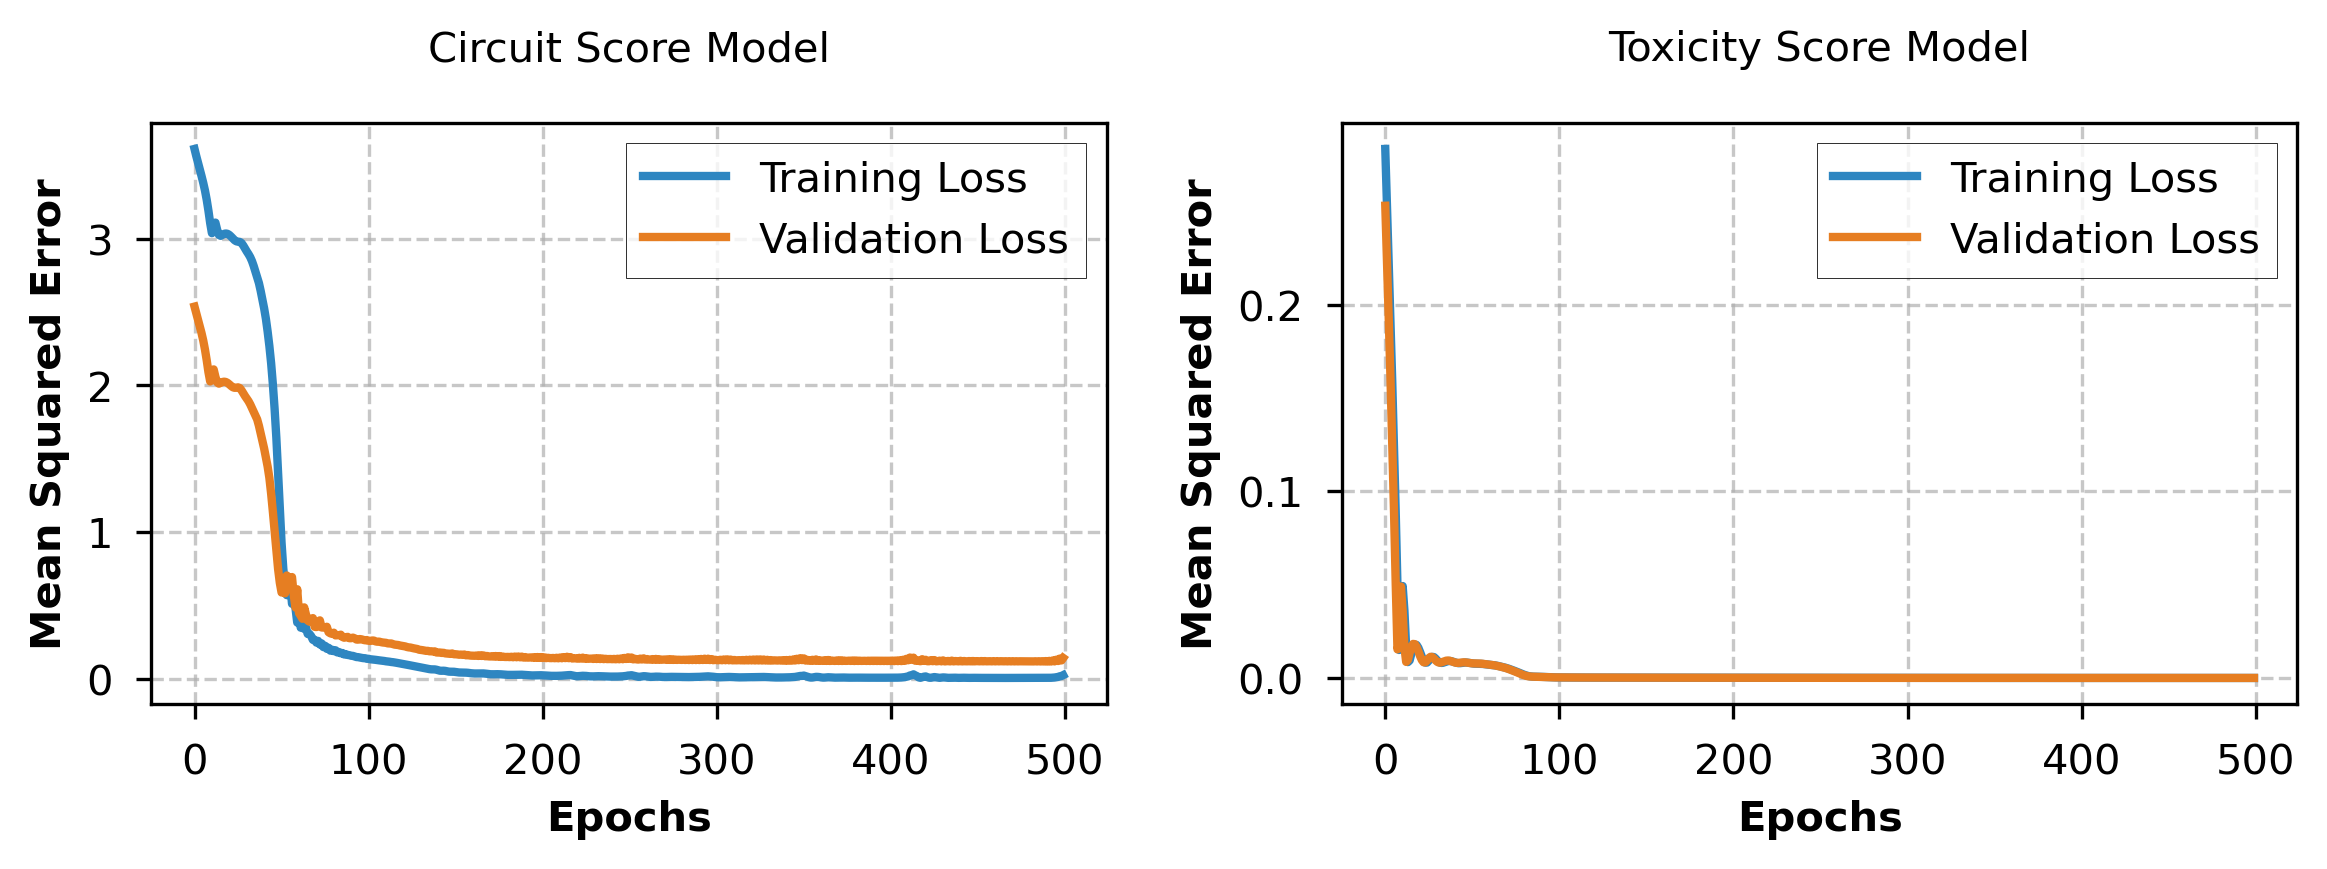

In [27]:
# Set the style for publication-quality plots
plt.style.use('seaborn-paper')
# Increase font sizes and set consistent font family
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',  # Changed from 'Arial' to 'sans-serif'
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Verdana'],  # Fallback fonts
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 10
})

# Create figure with larger size and higher DPI
plt.figure(figsize=(8, 3), dpi=300)

# First subplot
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), model_circuit_score_losses[0], label='Training Loss', 
         linewidth=2, color='#2E86C1')  # Professional blue color
plt.plot(range(num_epochs), model_circuit_score_losses[1], label='Validation Loss', 
         linewidth=2, color='#E67E22')  # Professional orange color
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Mean Squared Error', fontweight='bold')
plt.title('Circuit Score Model', pad=15)
plt.legend(frameon=True, fancybox=False, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), model_toxicity_score_losses[0], label='Training Loss',
         linewidth=2, color='#2E86C1')
plt.plot(range(num_epochs), model_toxicity_score_losses[1], label='Validation Loss',
         linewidth=2, color='#E67E22')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Mean Squared Error', fontweight='bold')
plt.title('Toxicity Score Model', pad=15)
plt.legend(frameon=True, fancybox=False, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

### After training, save the models

In [28]:
def save_model(model, filepath):
    # If the model is wrapped in DataParallel, we need to save the underlying model's state_dict
    if isinstance(model, nn.DataParallel):
        th.save(model.module.state_dict(), filepath)
    else:
        th.save(model.state_dict(), filepath)

# Save the circuit score model
save_model(model_circuit_score, f'model_circuit_score_{circuit_name}.pth')

# Save the toxicity score model
save_model(model_toxicity_score, f'model_toxicity_score_{circuit_name}.pth')

###  Load trained model 

In [29]:
# Initialize the models
input_size = num_biological_parts * num_classes # Must match the input size used during training
hidden_size = 200    # Must match the hidden size used during training
output_size = 1      # Must match the output size used during training

model_circuit_score = RegressionNN(input_size, hidden_size, output_size)
model_toxicity_score = RegressionNN(input_size, hidden_size, output_size)

# Load the state dictionaries
def load_model(model, filepath):
    state_dict = th.load(filepath, map_location=th.device('cpu'))
    model.load_state_dict(state_dict)

load_model(model_circuit_score, f'model_circuit_score_{circuit_name}.pth')
load_model(model_toxicity_score, f'model_toxicity_score_{circuit_name}.pth')

## Predictions

In [30]:
import time
X_valid_permutations = np.array(valid_permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
# Convert X_filtered to PyTorch tensor and perform one-hot encoding
X_valid_permutations_tensor = th.from_numpy(X_valid_permutations).long()
X_valid_permutations_tensor_one_hot = F.one_hot(X_valid_permutations_tensor, num_classes=20).float()

print("Converted to tensors")

Converted to tensors


## When using nodes with GPUs 

In [31]:
import time

# Unwrap models from DataParallel and move them to CPU
model_circuit_score = model_circuit_score.cpu()
model_toxicity_score = model_toxicity_score.cpu()

print("Moved models to CPU")

# Prediction
model_circuit_score.eval()
model_toxicity_score.eval()

# Calculate the start time
print("Performing predictions")
with th.no_grad():
    # Perform predictions on CPU
    start = time.time()
    
    y_predicted_circuit_scores = model_circuit_score(X_valid_permutations_tensor_one_hot).cpu().numpy().flatten()
    y_predicted_toxicity_scores = model_toxicity_score(X_valid_permutations_tensor_one_hot).cpu().numpy().flatten()
    
    # Calculate the end time and time taken
    end = time.time()
    duration = end - start
    print("")
    print("Done performing predictions. Time to make predictions: ", duration)

Moved models to CPU
Performing predictions

Done performing predictions. Time to make predictions:  1.5863852500915527


In [49]:
print("test")

### Characterize performance on the test set

In [32]:
# Get model predictions on test set
model_circuit_score.eval()
model_toxicity_score.eval()

# Move test data and models to CPU
model_circuit_score = model_circuit_score.cpu()
model_toxicity_score = model_toxicity_score.cpu()
X_test_set_cpu = X_test_set.cpu()

# Make predictions
with th.no_grad():
    test_pred_circuit = model_circuit_score(X_test_set_cpu)
    test_pred_toxicity = model_toxicity_score(X_test_set_cpu)

# Convert everything to numpy arrays for plotting
test_pred_circuit = test_pred_circuit.numpy().flatten()
test_pred_toxicity = test_pred_toxicity.numpy().flatten()
test_actual_circuit = y_circuit_scores_test_set.cpu().numpy().flatten()
test_actual_toxicity = y_toxicity_scores_test_set.cpu().numpy().flatten()

/state/partition1/slurm_tmp/1102848.0.0/ipykernel_3321421/1854601656.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


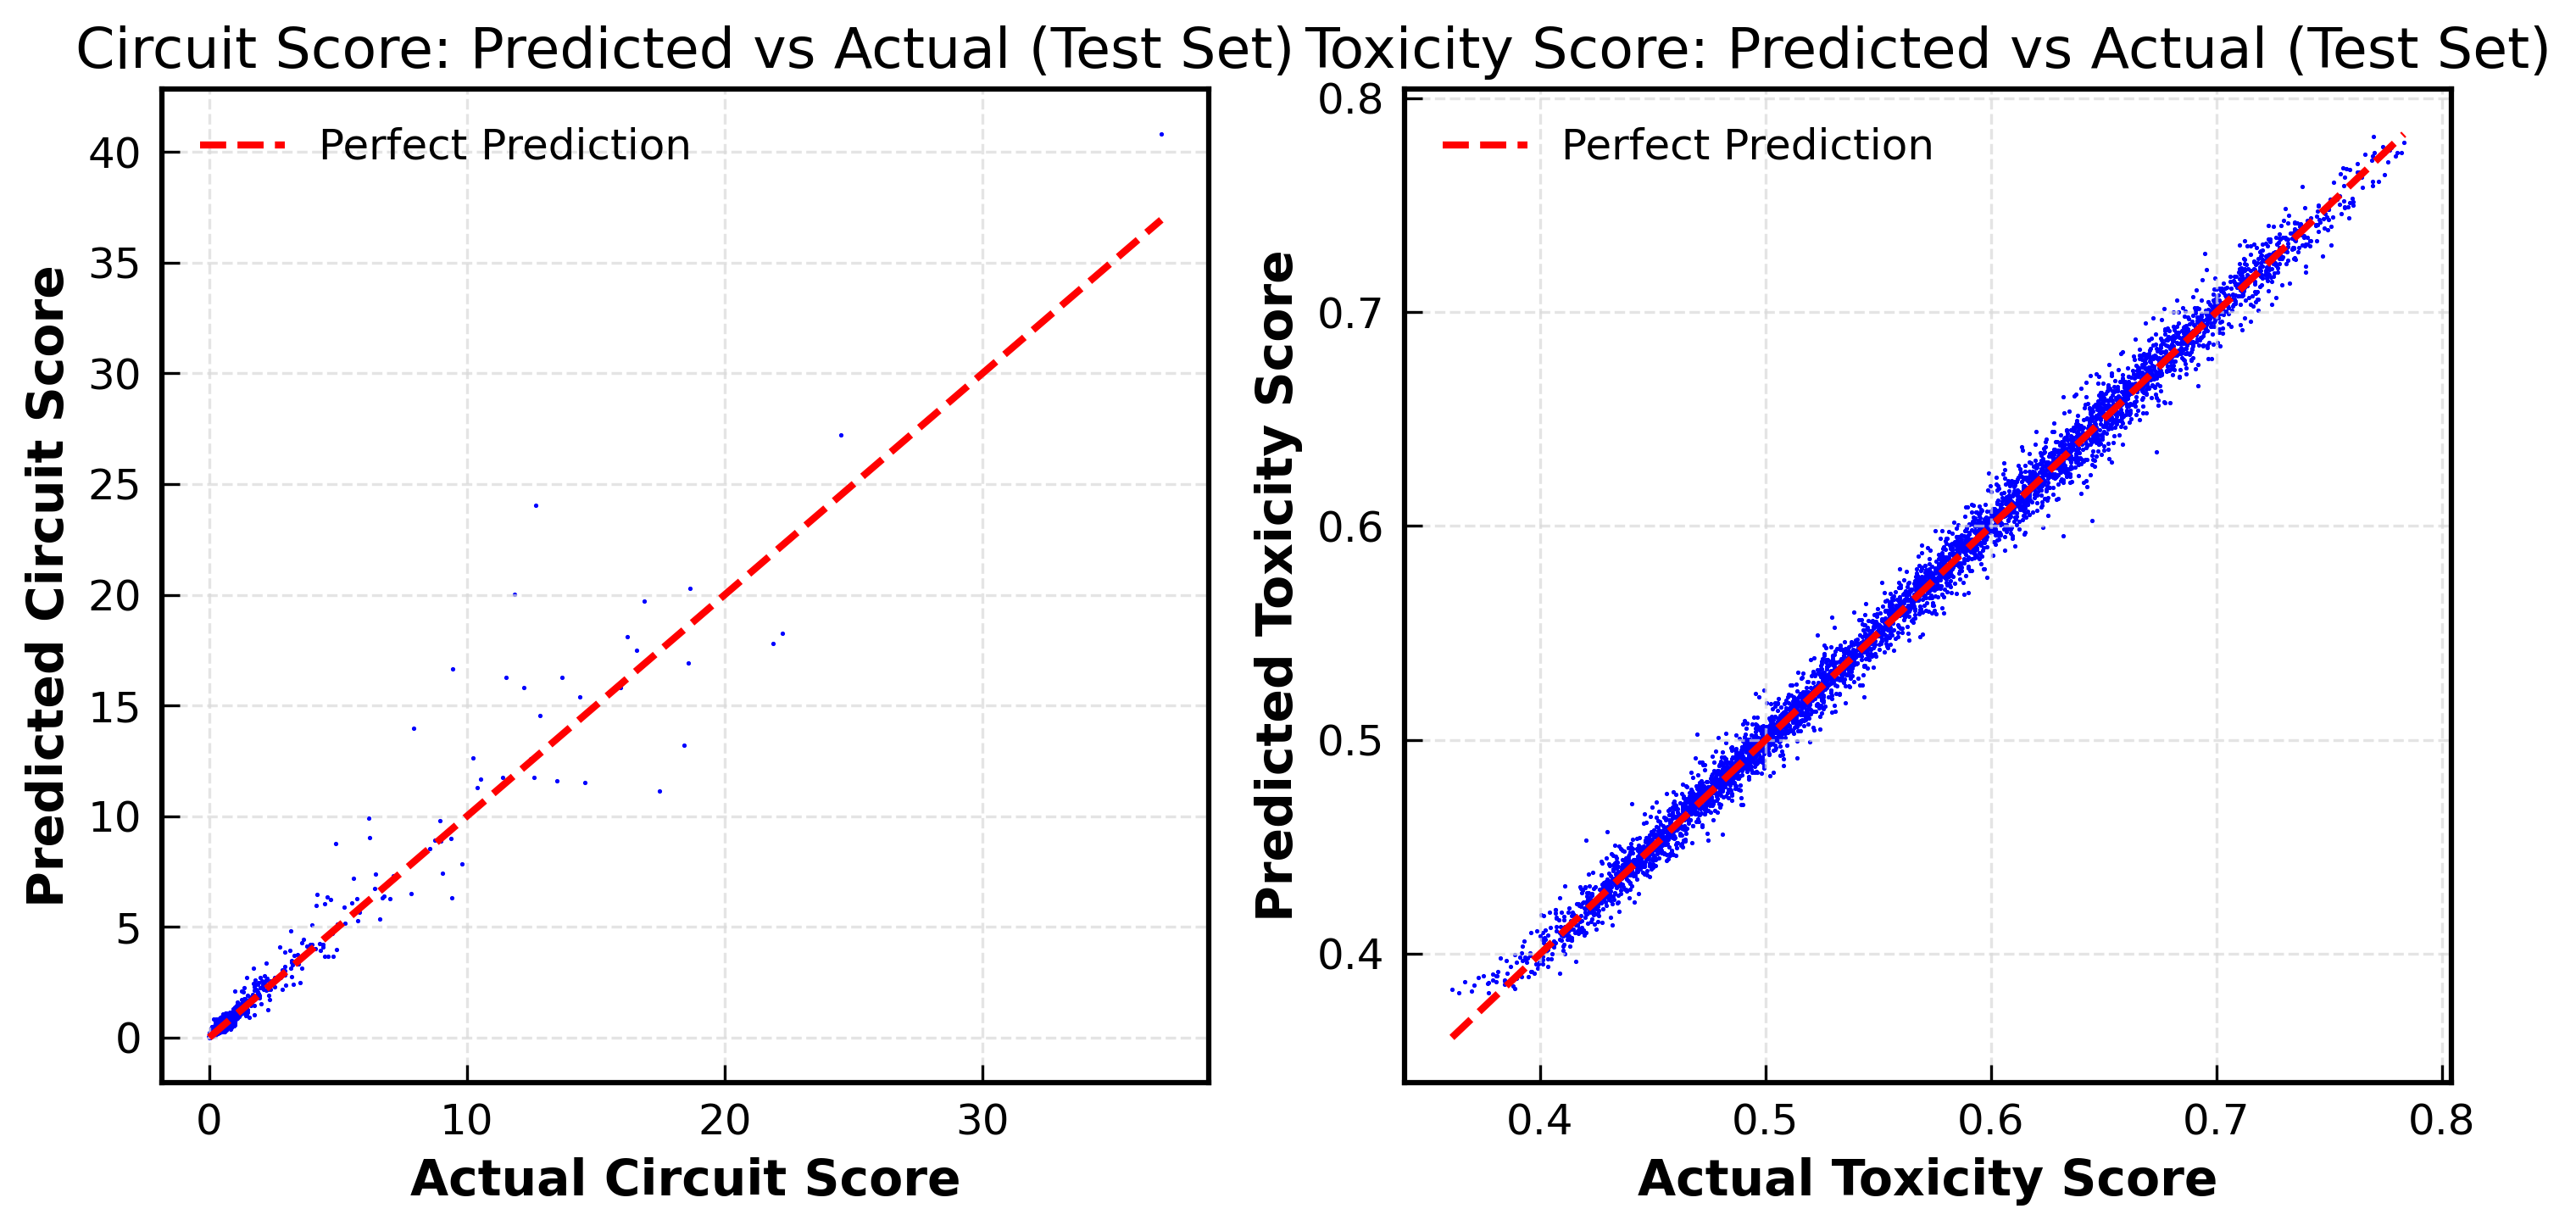


Test Set Circuit Score Metrics:
MSE: 0.1402
RMSE: 0.3744
R² Score: 0.9307
Correlation Coefficient: 0.9708

Test Set Toxicity Score Metrics:
MSE: 0.0001
RMSE: 0.0073
R² Score: 0.9937
Correlation Coefficient: 0.9969


In [37]:
# Create 2D comparison plots
import matplotlib as mpl
plt.style.use('seaborn-paper')
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 12,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False
})
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# Circuit Score comparison plot
ax1.scatter(test_actual_circuit, test_pred_circuit, 
           alpha=1, s=1, color='blue')
ax1.plot([min(test_actual_circuit), max(test_actual_circuit)], [min(test_actual_circuit), max(test_actual_circuit)], 'r--', label='Perfect Prediction')
ax1.set_xlabel('Actual Circuit Score', fontweight='bold')
ax1.set_ylabel('Predicted Circuit Score', fontweight='bold')
ax1.set_title('Circuit Score: Predicted vs Actual (Test Set)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Toxicity Score comparison plot
ax2.scatter(test_actual_toxicity, test_pred_toxicity, 
           alpha=1, s=1, color='blue')
ax2.plot([min(test_actual_toxicity), max(test_actual_toxicity)],[min(test_actual_toxicity), max(test_actual_toxicity)], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Actual Toxicity Score', fontweight='bold')
ax2.set_ylabel('Predicted Toxicity Score', fontweight='bold')
ax2.set_title('Toxicity Score: Predicted vs Actual (Test Set)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Add correlation coefficients
test_circuit_corr = np.corrcoef(test_actual_circuit, test_pred_circuit)[0,1]
test_toxicity_corr = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0,1]

#ax1.text(0.05, 0.95, f'r = {test_circuit_corr:.3f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top')
#ax2.text(0.05, 0.95, f'r = {test_toxicity_corr:.3f}', transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('test_set_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistical measures
from sklearn.metrics import mean_squared_error, r2_score

# Circuit Score metrics
test_circuit_mse = mean_squared_error(test_actual_circuit, test_pred_circuit)
test_circuit_rmse = np.sqrt(test_circuit_mse)
test_circuit_r2 = r2_score(test_actual_circuit, test_pred_circuit)

# Toxicity Score metrics
test_toxicity_mse = mean_squared_error(test_actual_toxicity, test_pred_toxicity)
test_toxicity_rmse = np.sqrt(test_toxicity_mse)
test_toxicity_r2 = r2_score(test_actual_toxicity, test_pred_toxicity)

print("\nTest Set Circuit Score Metrics:")
print(f"MSE: {test_circuit_mse:.4f}")
print(f"RMSE: {test_circuit_rmse:.4f}")
print(f"R² Score: {test_circuit_r2:.4f}")
print(f"Correlation Coefficient: {test_circuit_corr:.4f}")

print("\nTest Set Toxicity Score Metrics:")
print(f"MSE: {test_toxicity_mse:.4f}")
print(f"RMSE: {test_toxicity_rmse:.4f}")
print(f"R² Score: {test_toxicity_r2:.4f}")
print(f"Correlation Coefficient: {test_toxicity_corr:.4f}")



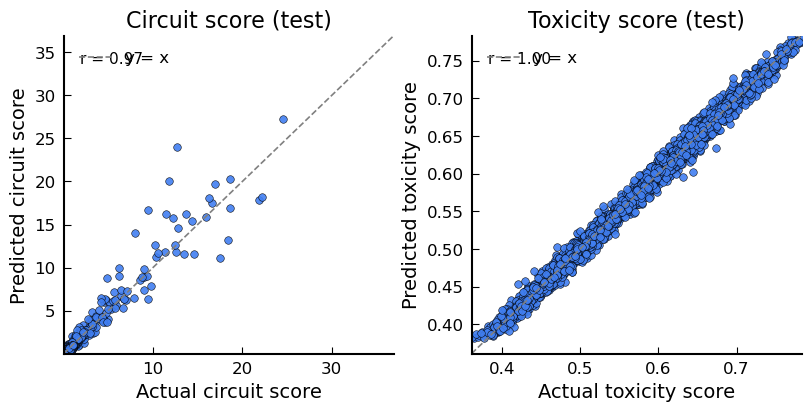

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------------------------------------
# 1.  GraphPad-style cosmetics  (copy-paste from your single-line plot)
# ------------------------------------------------------------------
plt.rcParams.update({
    "font.family"      : "sans-serif",
    "font.sans-serif"  : ["DejaVu Sans"],   # pick any installed font
    "font.size"        : 6,
    "axes.labelsize"   : 14,
    "axes.titlesize"   : 16,
    "axes.linewidth"   : 1.5,
    "lines.linewidth"  : 2,
    "xtick.labelsize"  : 12,
    "ytick.labelsize"  : 12,
    "xtick.direction"  : "in",
    "ytick.direction"  : "in",
    "xtick.major.size" : 5,
    "ytick.major.size" : 5,
    "legend.fontsize"  : 12,
    "legend.frameon"   : False,
    "savefig.dpi"      : 300,
    "figure.dpi"       : 100,
    "figure.figsize"   : (8, 4),            # width x height, inches
    "axes.grid"        : False,
})

# ------------------------------------------------------------------
# 2.  Figure & axes
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)

# Common scatter kwargs
scatter_kw = dict(
    s=30,                # ≈ 5 pt markers
    color='#417FF1',     # GraphPad-like blue
    edgecolors='black',  # thin outline
    linewidths=0.4,
    alpha=0.9
)

# ------------------------------------------------------------------
# 3.  Circuit-score panel
# ------------------------------------------------------------------
ax1.scatter(test_actual_circuit, test_pred_circuit, **scatter_kw)
lims = [min(test_actual_circuit), max(test_actual_circuit)]
ax1.plot(lims, lims, '--', color='gray', linewidth=1.2, label='y = x')
ax1.set_xlim(lims);  ax1.set_ylim(lims)

ax1.set_xlabel('Actual circuit score')
ax1.set_ylabel('Predicted circuit score')
ax1.set_title('Circuit score (test)')

# cosmetic touches
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.legend()

# ------------------------------------------------------------------
# 4.  Toxicity-score panel
# ------------------------------------------------------------------
ax2.scatter(test_actual_toxicity, test_pred_toxicity, **scatter_kw)
lims = [min(test_actual_toxicity), max(test_actual_toxicity)]
ax2.plot(lims, lims, '--', color='gray', linewidth=1.2, label='y = x')
ax2.set_xlim(lims);  ax2.set_ylim(lims)

ax2.set_xlabel('Actual toxicity score')
ax2.set_ylabel('Predicted toxicity score')
ax2.set_title('Toxicity score (test)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='both', direction='in')
ax2.legend()

# ------------------------------------------------------------------
# 5.  Optional correlation text
# ------------------------------------------------------------------
r_circ = np.corrcoef(test_actual_circuit, test_pred_circuit)[0, 1]
r_tox  = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0, 1]

ax1.text(0.05, 0.95, f'r = {r_circ:.2f}', transform=ax1.transAxes,
         ha='left', va='top', fontsize=11)
ax2.text(0.05, 0.95, f'r = {r_tox:.2f}', transform=ax2.transAxes,
         ha='left', va='top', fontsize=11)

# ------------------------------------------------------------------
# 6.  Save / show
# ------------------------------------------------------------------
plt.savefig('test_set_prediction_comparison_graphpad.svg',
            format='svg', bbox_inches='tight')
plt.show()


## Find top designs

#### Filter condition is where predicted circuit score is above a threshold

In [39]:
filter_condition_for_circuit_score = y_predicted_circuit_scores > 2


#### Select and save permutations predicted to be high-performing

In [40]:
gate_assignments_predicted_to_have_high_cricuit_score = X_valid_permutations[filter_condition_for_circuit_score]
# Save the array
np.save(f"gate_assignments_high_score{circuit_name}.npy", gate_assignments_predicted_to_have_high_cricuit_score)


#### Load permutations predicted to be high-performing

In [41]:
gate_assignments_predicted_to_have_high_cricuit_score = np.load(f"gate_assignments_high_score{circuit_name}.npy")

# Convert to list of tuples
gate_assignments_predicted_to_have_high_cricuit_score_list_of_tuples = [
    tuple(np.int64(x) for x in tup) 
    for tup in gate_assignments_predicted_to_have_high_cricuit_score
]


#### Calculate actual scores and save

In [42]:
# Initialize your graph and get adjacency matrix
Gi = permuted_graphs[0]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

# Set up output directory
output_dir = f"high_performing_circuit_results{circuit_name}"

# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=gate_assignments_predicted_to_have_high_cricuit_score_list_of_tuples,
    cello_params=cello_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=output_dir,
    num_samples=len(gate_assignments_predicted_to_have_high_cricuit_score_list_of_tuples),           # Total solutions to process
    batch_size=1000,              # Size of each processing batch
    solutions_per_file=500000     # Save every 500,000 solutions
    )

Utilizing all 80 cores for parallel processing
Solutions per file: 20,221
Expected number of files: 1
Selecting 20,221 random solutions from 20,221 valid permutations
All solutions have already been processed


#### Load actual scores if saved

In [43]:
# Specify your output directory
output_dir = f"high_performing_circuit_results{circuit_name}"

# Load all results
(permutations_high_performing, toxicity_scores_high_performing, 
 circuit_scores_high_performing, roadblocking_flags_high_performing) = load_circuit_results(output_dir)

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations_high_performing.shape}")
    print(f"Toxicity scores shape: {toxicity_scores_high_performing.shape}")
    print(f"Circuit scores shape: {circuit_scores_high_performing.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags_high_performing.shape}")

Found 1 batch files to load


Loading results:   0%|          | 0/1 [00:00<?, ?it/s]


Loading completed:
Total results loaded: 24,059
Unique permutations: 24,059
Average circuit score: 6.553
Average toxicity score: 0.610
Roadblocking percentage: 90.7%

Data shape summary:
Permutations shape: (24059, 5)
Toxicity scores shape: (24059,)
Circuit scores shape: (24059,)
Roadblocking flags shape: (24059,)


### List top biological designs 

In [44]:
no_roadblock_mask = ~roadblocking_flags_high_performing

In [45]:
permutations_high_performing_no_roadblocking = permutations_high_performing[no_roadblock_mask]
circuit_scores_high_performing_no_roadblocking = circuit_scores_high_performing[no_roadblock_mask]
toxicity_scores_high_performing_no_roadblocking = toxicity_scores_high_performing[no_roadblock_mask]
roadblocking_flags_high_performing_no_roadblocking = roadblocking_flags_high_performing[no_roadblock_mask]

In [46]:
toxicity_filter = toxicity_scores_high_performing_no_roadblocking >= 0.75

In [47]:
permutations_high_performing_no_roadblocking_toxicity_filtered = permutations_high_performing_no_roadblocking[toxicity_filter]
circuit_scores_high_performing_no_roadblocking_toxicity_filtered = circuit_scores_high_performing_no_roadblocking[toxicity_filter]
toxicity_scores_high_performing_no_roadblocking_toxicity_filtered = toxicity_scores_high_performing_no_roadblocking[toxicity_filter]
roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered = roadblocking_flags_high_performing_no_roadblocking[toxicity_filter]

In [48]:
print(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)

[ 2.15113923  8.21283838  5.50247476  2.0461876   3.75201685  7.82940378
  7.83868954 13.45951067 10.50913063 12.1139447   4.314033    2.79848939
 26.53994917  1.81435142 17.02409316  4.73831885  3.19142545  1.95187293
  4.51873303  4.0834245   8.15033431  5.32366568  3.14150845  4.07441491
  3.58589053  1.94295214  4.7005218   2.66477624  3.40814847  3.13351137
  2.83437061  2.14831412  5.72269465  2.1635924   6.06374257  6.95959048
  6.48199317  9.04809156  6.45719658 12.6603572   2.48072459  5.24276543
  3.71708744  2.06888771  2.78732324  5.26644298  6.63777767  8.07873453
  3.75968763  7.13671521 18.40696373 10.51274019  5.75116162  2.34514279
 11.44648672 14.14924546  3.13639611  5.68656987  4.88162156  6.19124874
  2.21669972  1.73118659  2.75301069  9.63751489 11.00510553  6.60844124
 26.93014364  4.60171227  3.98236772  4.75192507  7.7738779 ]


### Search only for circuits without Bet NOR

In [49]:
from dgd.utils.utils5 import validate_graph_incoming_signals

In [50]:
gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}

# Create DataFrame
gate_max_incoming_signals_df = pd.DataFrame(gate_max_incoming_signals)

In [51]:
valid_NOR_NOT_assignments_flags = []

for perm in (permutations_high_performing_no_roadblocking_toxicity_filtered):
    Gtest = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, perm)
    valid_NOR_NOT_assignments_flags.append(validate_graph_incoming_signals(Gtest, cello_v1_hill_function_parameters, gate_max_incoming_signals_df))

In [52]:
num_true = sum(valid_NOR_NOT_assignments_flags)
num_true

22

In [56]:
N = 20

In [57]:
# Get indices where validation flags are True
valid_indices = [i for i, flag in enumerate(valid_NOR_NOT_assignments_flags) if flag]

# Filter scores to only include valid circuits
top_n_indices = np.argsort([circuit_scores_high_performing_no_roadblocking_toxicity_filtered[i] for i in valid_indices])[-N:][::-1]
valid_indices_array = np.array(valid_indices)

print(f"\nTop {N} Valid Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

highest_score_details = {}
for rank, idx in enumerate(top_n_indices, 1):
    corresponding_index = valid_indices_array[idx]
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")
    
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'roadblocking': roadblock_flag,
            'permutation': best_permutation
        }

print("\n" + "="*50)
print("Detailed information for highest scoring valid design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
print(f"Permutation: {highest_score_details['permutation']}")


Top 20 Valid Circuit Scores (no roadblocking, toxicity > 0.75):
Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation
----------------------------------------------------------------------------------------------------
   1 |       7.8294 |        0.7507 | False       | [ 2  1 11 13 15]
   2 |       6.6084 |        0.7546 | False       | [ 2  1 12 13 15]
   3 |       6.4572 |        0.8014 | False       | [ 2  1 19 13 15]
   4 |       4.7005 |        0.7782 | False       | [ 2  1 17 13 15]
   5 |       4.5187 |        0.7811 | False       | [ 2  1  4 13 15]
   6 |       4.0744 |        0.7814 | False       | [ 2  1  5 13 15]
   7 |       3.9824 |        0.7535 | False       | [ 2  1  5 13 19]
   8 |       3.7597 |        0.7548 | False       | [ 2  1  5  0 15]
   9 |       3.7520 |        0.7545 | False       | [ 2  1  4  0 15]
  10 |       3.7171 |        0.7624 | False       | [ 2  1 18 13 15]
  11 |       3.4081 |        0.7532 | False       | [ 2  1  4 13 19]
  12 |  

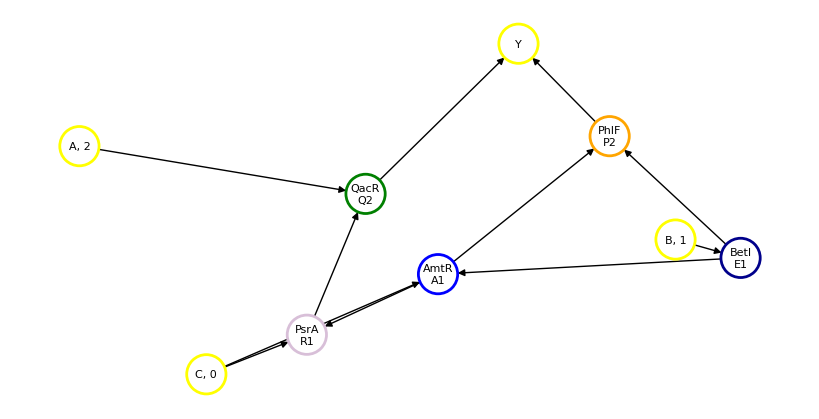

In [58]:
G = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, highest_score_details['permutation'])
draw_network_with_colors_and_labels_from_G(G)

Export to CSV

In [60]:
import csv


rows = []
for rank, idx in enumerate(top_n_indices, 1):
    corr_idx = valid_indices_array[idx]
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Toxicity Score"  : toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Roadblocking"    : roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Permutation"     : permutations_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
    })

# ------------------------------------------------------------
#  A.  Super-lightweight approach with the std-lib csv module
# ------------------------------------------------------------
csv_path = "top_valid_circuits.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n✓ Saved {len(rows)} rows to {csv_path}")


✓ Saved 20 rows to top_valid_circuits.csv


## Previous code

In [69]:
# Find top N circuit scores
N = 20  # Change this number to get more or fewer top scores
top_n_indices = np.argsort(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)[-N:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N} Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details = {}

for rank, idx in enumerate(top_n_indices, 1):
    # Get the corresponding index in the original filtered arrays
    corresponding_index = idx

    # Get permutation
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Get roadblocking flag for this design
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Print formatted output
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'roadblocking': roadblock_flag,
            #'predicted_circuit': y_pred_circuit_filtered[corresponding_index],
            #'predicted_toxicity': y_pred_toxicity_filtered[corresponding_index],
            'permutation': best_permutation
        }

# Print detailed information for highest scoring design after the table
print("\n" + "="*50)
print("Detailed information for highest scoring design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
#print(f"Predicted circuit score: {highest_score_details['predicted_circuit']}")
#print(f"Predicted toxicity score: {highest_score_details['predicted_toxicity']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [70]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N + 1))
circuit_scores = circuit_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]
toxicity_scores = toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Top Performing Circuits', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

# Optional: Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores):.3f}, Std: {np.std(circuit_scores):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores):.3f}, Std: {np.std(toxicity_scores):.3f}")

#### Draw the top design

In [71]:
G = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, highest_score_details['permutation'])
draw_network_with_colors_and_labels_from_G(G)